In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sy
import time
from pycqed import *

# Qubit-Resonator Example

Resonators are used extensively for Quantum Non-Demolition (QND) measurements of circuit observables. Here we show how to couple a resonator capacitively to an RF-SQUID qubit, and determine the resonator modulation and shifts dependent on the qubit state. Currently the code uses the RWA approximation and assumes weak coupling. See [A. Blais _et al_][1] for the background to qubit-resonator coupling in the dispersive limit, and see [D. Sank _et al_][2] for the methodology adopted for calculating the interaction Hamiltonian and the response of the resonator.

[1]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.062320
[2]: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.190503

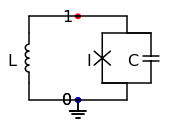

In [2]:
circuit = CircuitSpec("Original Flux Qubit Circuit")
circuit.addBranch(["L"],"up",0,False,arm_len=0.5)
circuit.addBranch(["I","C"],"down",1,True,arm_len=0.5)
circuit.drawCircuit(inline=True)

For a capacitively coupled resonator, all that is required for drawing is a choice of node to which the resonator will be coupled. A new `CircuitSpec` instance will be created that considers the system as a whole. This new instance is used to account for loading of each circuit and it can be used to get the spectrum of the system as a whole.

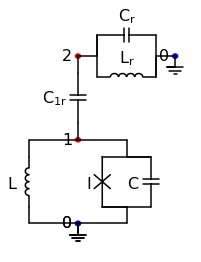

In [3]:
rcircuit = circuit.coupleLinearResonator("r",1)
rcircuit.drawCircuit(inline=True)

We can compare the inverse capacitance matrices of the two systems:

In [4]:
circuit.getInverseCapacitanceMatrix()

Matrix([[1/C_{}]])

In [5]:
rcircuit.getInverseCapacitanceMatrix()

Matrix([
[(C_{1r} + C_{r})/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{})),          C_{1r}/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{}))],
[          C_{1r}/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{})), (C_{1r} + C_{})/(-C_{1r}**2 + (C_{1r} + C_{r})*(C_{1r} + C_{}))]])

The terms that describe the qubit-resonator coupling strength are the off diagonals of this matrix. We can show the charge terms of the circuit Hamiltonian:

In [6]:
rcircuit.getChargingEnergies().expand()

Matrix([[0.5*C_{1r}*Q_{1}*Q_{2}/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{}) + 0.5*C_{1r}*Q_{1}**2/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{}) + 0.5*C_{1r}*Q_{2}*Q_{1}/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{}) + 0.5*C_{1r}*Q_{2}**2/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{}) + 0.5*C_{r}*Q_{1}**2/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{}) + 0.5*C_{}*Q_{2}**2/(C_{1r}*C_{r} + C_{1r}*C_{} + C_{r}*C_{})]])

The terms involving $Q_1$ and $Q_2$ form the interaction part of the Hamiltonian. Since $Q_1$ and $Q_2$ commute, we will have

$$\hat{H}_\mathrm{int} = \frac{C_{1r} \hat{Q}_1 \hat{Q}_2}{C_{1r} C_r + C_{1r} C + C_r C} = g_0 \hat{Q}_1 \hat{Q}_2$$

where $g_0$ is the coupling constant of the system that depends only on the circuit capacitances.

The diagonal terms in the matrix describe the self-interacting terms. We see that the capacitance seen at node 1 is now different when the resonator is included. This is the capacitive loading effect. Similarly the Capacitance seen at node 2 is different, so we can expect the resonant frequency to be affected by the qubit circuit also.

### Resonator Subsystem

We then need to initialise the `HamilSpec` instance to include the subsystem, here the linear resonator, in the calculations. This way all the resonator properties are registered as entities that can be evaluated during parameter sweeps. Currently only one subsystem is supported.

In [7]:
hamil = HamilSpec(circuit,include_subsystem="r")
hamil.setTruncation(1,20,"charge")
hamil.prepareOperators()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


We see the resonator parameters have been added to the main parameter list:

In [8]:
hamil.all_params_sym

{'L': L_{},
 'C': C_{},
 'I': I_{},
 'C1r': C_{1r},
 'Cr': C_{r},
 'Lr': L_{r},
 'phi10e': \Phi_{10e}}

Before we do sweeps of the resonator response, we need to configure the diagonaliser to return the eigenvectors of the Hamiltonian at each point, as the calculation depends on these. We also ask for more than the default 5 eigenvalues to be returned to ensure sufficient coupling terms are calculated when building the RWA strips:

In [9]:
hamil.setDiagConfig(get_vectors=True,eigvalues=20)

Since the resonator response depends on the Hamiltonian, we configure the sweeper to use the results obtained from it. We can also use the `eval_dp` of the `getResonatorResponse` function to save the derived parameters during a sweep. For a linear resonator these parameters include the impedance, the bare resonant frequency and the coupling strength in the selected energy unit.

In [10]:
# Configure the parameter sweep
spec = [
    hamil.sweepSpec('phi10e',0.49,0.51,401)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getResonatorResponse',False,"getHamiltonian",eval_dp=True),
]

Now we set the parameter values of the qubit and the resonator. We will choose a small coupling capacitor of 5 fF:

In [11]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2

hamil.setParameterValues('L',550,'C',Ca*Aj,'I',Jc*Aj,'phi10e',0.5,'Cr',400.0,'Lr',1000.0,'C1r',0.5)

Now we do the sweep:

In [12]:
sweep = hamil.paramSweep(spec,eval_spec=evals)

The `getResonatorResponse` function returns the full set of dressed qubit eigenvalues for each number of resonator photons specified. The default is 100, and this can be set as keyword arguments passed to the `evalSpec` entry of for `getResonatorResponse`. Let's first look at the spectrum of the bare capacitively loaded RF-SQUID:

In [13]:
x,EV,v = hamil.getSweep(sweep,'phi10e',{},evaluable='getHamiltonian')
E = EV[:,0]
V = EV[:,1]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

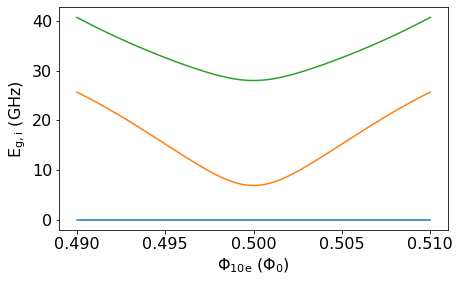

In [14]:
for i in range(3):
    y = E[i] - E[0]
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

### Resonator Parameters

The derived parameters of the subsystem are saved in a nested dictionary. The available subsystems are:

In [15]:
hamil.getSubsystemList()

['r']

The available subsystem derived parameters are:

In [16]:
hamil.getSubsystemDerivedParametersList('r')

['Z', 'w', 'gC', 'gL']

Now we can get the values of, say, the impedance as a function of the sweep performed above:

Text(0, 0.5, '$\\omega_r$ (GHz)')

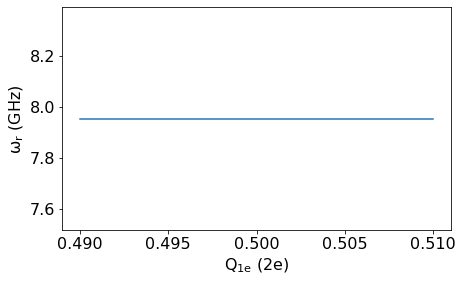

In [17]:
plt.plot(x,hamil.getSubsystemDerivedParameter('w'),ls="-")
plt.xlabel("$Q_{1e}$ ($2e$)")
plt.ylabel("$\\omega_r$ (GHz)")

As expected the bare resonant frequency should not change here as we have not swept a circuit parameter, similarly for the others:

In [18]:
for k in hamil.getSubsystemDerivedParametersList('r'):
    print ("%s = %e" % (k,hamil.getSubsystemDerivedParameter(k)[0]))

Z = 4.996983e+01
w = 7.952945e+00
gC = 4.162487e-02
gL = 0.000000e+00


### Circuit Lamb Shift

Now let's look at the dressed (Lamb shifted) spectrum of the capacitively loaded RF-SQUID, which can be extracted using the `getCircuitLambShift` utility function:

In [19]:
x,Erwa,v = hamil.getSweep(sweep,'phi10e',{},evaluable='getResonatorResponse')
Edressed = util.getCircuitLambShift(Erwa)

Text(0, 0.5, '$E_{g,i}$ (GHz)')

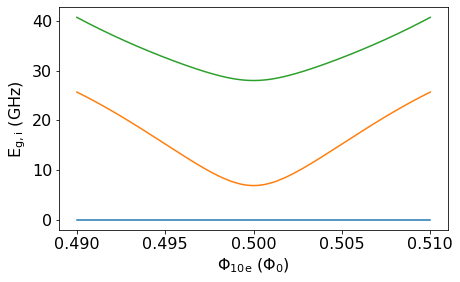

In [20]:
for i in range(3):
    y = Edressed[i]
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Because the coupling here is small compared to the total Hamiltonian, we cannot easily see the avoided crossing region where the qubit energy crosses the resonator resonant frequency. We can more easily see this by focusing in that region:

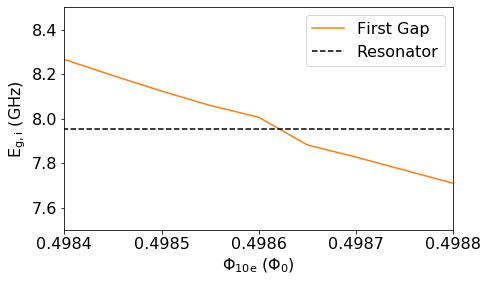

In [21]:
# Get the loaded bare resonator frequency
wr = hamil.dpnp['w']

#
plt.plot(x,Edressed[1],"C1-",label="First Gap")
plt.plot([x[0],x[-1]],[wr,wr],"k--",label="Resonator")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.xlim(0.4984,0.4988)
plt.ylim(7.5,8.5)
plt.legend()

We can observe the Lamb shift directly by taking the difference of the dressed levels with those of the (loaded) isolated qubit:

Text(0, 0.5, '$\\Delta E_{g,i}$ (MHz)')

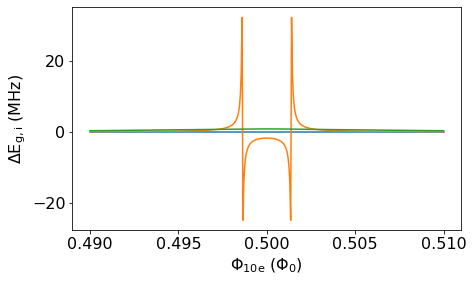

In [22]:
for i in range(3):
    y = (Edressed[i] - (E[i] - E[0]))*1e3
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\Delta E_{g,i}$ (MHz)")

### Resonator Shift

Now let's look at the resonator modulation when the qubit is in the ground as the external flux is changed. We can use the `getResonatorShift` utility function to extract this:

In [23]:
Eres = util.getResonatorShift(Erwa)

Text(0, 0.5, '$\\omega_{r}$ (GHz)')

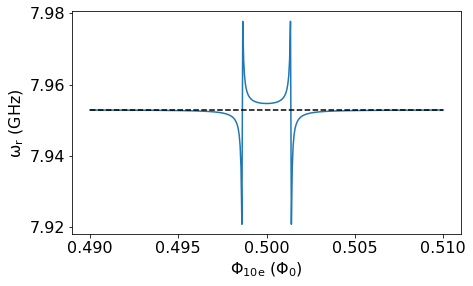

In [24]:
plt.plot(x,Eres[0,0])
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")

As expected we see the resonator shift change sign in the region where the qubit energy is less than the resonator frequency. The shift near half flux is on the order of a MHz.

Now we can look at the resonator frequency when the qubit is in different excited states:

Text(0, 0.5, '$\\omega_{r}$ (GHz)')

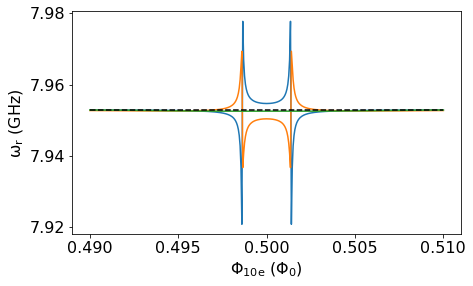

In [25]:
plt.plot(x,Eres[0,0],label="Gnd State")
plt.plot(x,Eres[1,0],label="Ex State 1")
plt.plot(x,Eres[2,0],label="Ex State 2")
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")

We can plot the change in frequency when the qubit goes from the ground state to the first and second excited states by taking the difference with the ground state resonator modulation curve:

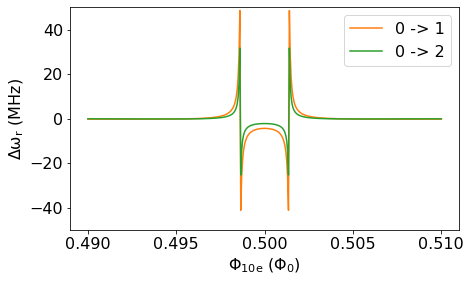

In [26]:
plt.plot(x,(Eres[1,0]-Eres[0,0])*1e3,"C1-",label="0 -> 1")
plt.plot(x,(Eres[2,0]-Eres[0,0])*1e3,"C2-",label="0 -> 2")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\Delta\omega_{r}$ (MHz)")
plt.ylim(-50,50)
plt.legend()

We see that for these parameters, the shift of the resonator when the qubit is excited is on the order of 10 MHz. We also see that the resonator is affected very little for a small flux away from half flux. This is due to the qubit energy becoming so large in those regions that the resonator and qubit are effectively decoupled.

### AC Stark Shift

Now we can look at the AC Stark shift of the qubit energy levels as the average number of photons in the resonator is increased. We can use the utility function `getACStarkShift` to extract these:

In [27]:
n, Eacstark = util.getACStarkShift(Erwa)

Now we can plot the AC Stark shifted energy gaps as a function of the photon number at half flux:

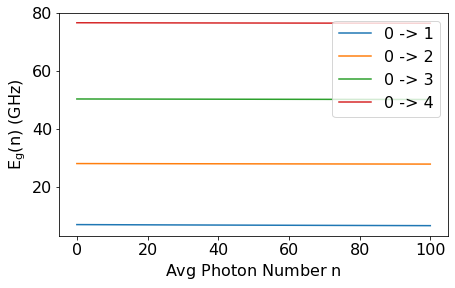

In [28]:
for i in range(4):
    plt.plot(n,Eacstark[i,:,200],label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$E_g(n)$ (GHz)")
plt.legend()

To get the AC Stark shift itself, we can take the difference with the Lamb shifted levels:

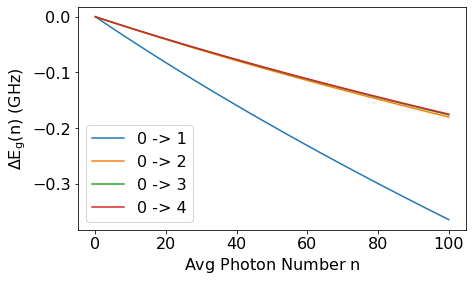

In [29]:
for i in range(4):
    plt.plot(n,Eacstark[i,:,200]-Edressed[i+1,200],label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\Delta E_g(n)$ (GHz)")
plt.legend()

We see the AC Stark shift is negative, as is expected in these types of qubits, and is also quite large. The effect of the AC Stark shift of the qubit can be observed on the resonator also, since the resonator shift depends on the qubit energy. We can plot this shift using the result from `getResonatorShift`:

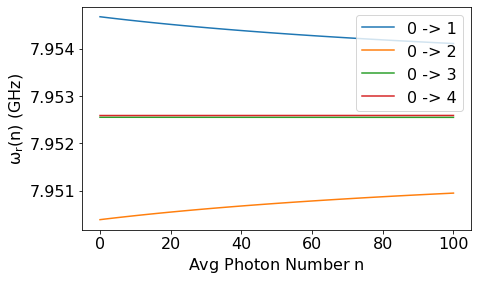

In [30]:
for i in range(4):
    plt.plot(n,Eres[i,:,200],label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\omega_r(n)$ (GHz)")
plt.legend()

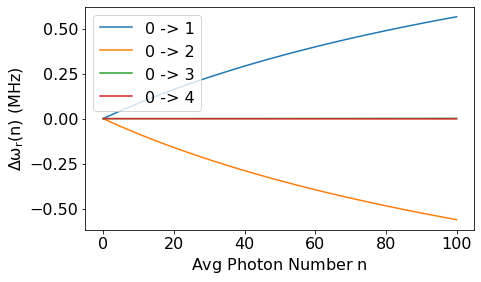

In [31]:
for i in range(4):
    plt.plot(n,(Eres[i,0,200]-Eres[i,:,200])*1e3,label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\Delta\\omega_r(n)$ (MHz)")
plt.legend()

### Capacitive Loading

To illustrate the effect of capacitive loading, we can initialise two `HamilSpec` instances, where one includes the resonator subsystem:

In [32]:
# Unloaded system
hamil_unloaded = HamilSpec(circuit)
hamil_unloaded.setTruncation(1,20,"charge")
hamil_unloaded.prepareOperators()
spec1 = [
    hamil_unloaded.sweepSpec('phi10e',0.4,0.6,101)
]


# Loaded system
hamil_loaded = HamilSpec(circuit,include_subsystem="r")
hamil_loaded.setTruncation(1,20,"charge")
hamil_loaded.prepareOperators()
spec2 = [
    hamil_loaded.sweepSpec('phi10e',0.4,0.6,101)
]

# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2

# Set the parameters
hamil_unloaded.setParameterValues('L',550,'C',Ca*Aj,'I',Jc*Aj,'phi10e',0.5)
hamil_loaded.setParameterValues('L',550,'C',Ca*Aj,'I',Jc*Aj,'phi10e',0.5,'Cr',400.0,'Lr',1000.0,'C1r',0.5)

# Do the sweeps
sweep1 = hamil_unloaded.paramSweep(spec1)
sweep2 = hamil_loaded.paramSweep(spec2)

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.
Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


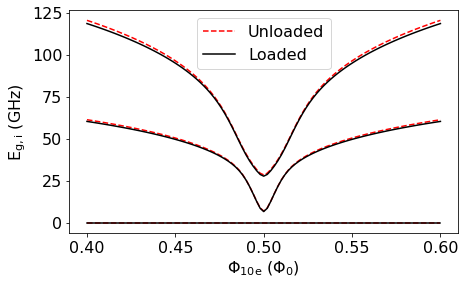

In [33]:
x1,E1,v = hamil_unloaded.getSweep(sweep1,'phi10e',{})
x1,E2,v = hamil_unloaded.getSweep(sweep2,'phi10e',{})

for i in range(3):
    y1 = E1[i] - E1[0]
    y2 = E2[i] - E2[0]
    if i == 0:
        plt.plot(x1,y1,"r--",label="Unloaded")
        plt.plot(x1,y2,"k-",label="Loaded")
    else:
        plt.plot(x1,y1,"r--")
        plt.plot(x1,y2,"k-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.legend()

(0, 50)

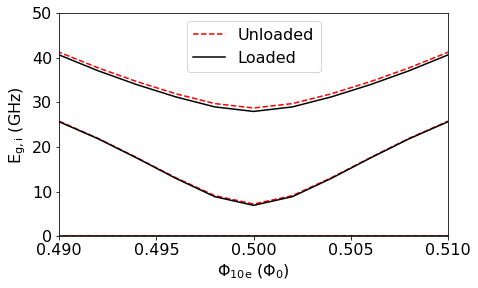

In [34]:
for i in range(3):
    y1 = E1[i] - E1[0]
    y2 = E2[i] - E2[0]
    if i == 0:
        plt.plot(x1,y1,"r--",label="Unloaded")
        plt.plot(x1,y2,"k-",label="Loaded")
    else:
        plt.plot(x1,y1,"r--")
        plt.plot(x1,y2,"k-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.legend()
plt.xlim(0.49,0.51)
plt.ylim(0,50)

We see for this circuit that the capacitive loading has a significant effect. This is due to the fact the qubit has a very small capacitance due only to the Josephson junction. The addition of the resonator acts as a shunt capacitor. By including a shunt capacitor much larger than $C_{1r}C_{r}/C_{1r}+C_{r}$, the loading effect would be negligible.

### Full Circuit Spectrum

Now we look at the full circuit spectrum to illustrate the importance of treating a coupled resonator as a subsystem for qubit applications. To do this we can use the full circuit object returned by the `coupleLinearResonator` function:

In [35]:
hamil = HamilSpec(rcircuit)
hamil.setTruncation(1,20,"charge")
hamil.setTruncation(2,20,"charge")
hamil.prepareOperators()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


In [36]:
hamil.setParameterValues('L',550,'C',Ca*Aj,'I',Jc*Aj,'phi10e',0.5,'Cr',400.0,'Lr',1000.0,'C1r',0.5)
spec = [
    hamil.sweepSpec('phi10e',0.4984,0.4988,101)
]
hamil.setDiagConfig(eigvalues=20)
sweep = hamil.paramSweep(spec)

We will compare the full spectrum to the reconstructed dressed states of the loaded system:

In [37]:
hamil_loaded.setParameterValues('L',550,'C',Ca*Aj,'I',Jc*Aj,'phi10e',0.5,'Cr',400.0,'Lr',1000.0,'C1r',0.5)
spec2 = [
    hamil_loaded.sweepSpec('phi10e',0.4984,0.4988,101)
]

hamil_loaded.setDiagConfig(get_vectors=True)
sweep2 = hamil_loaded.paramSweep(spec2,eval_spec=evals)

xl,Erwal,vl = hamil_loaded.getSweep(sweep2,'phi10e',{},evaluable='getResonatorResponse')
Edressedl = util.getCircuitLambShift(Erwal)

Text(0, 0.5, '$E_{g,i}$ (GHz)')

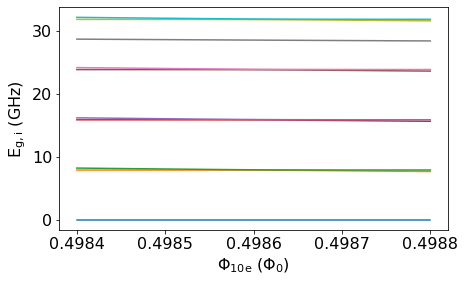

In [38]:
x,Efull,v = hamil.getSweep(sweep,'phi10e',{})
for i in range(10):
    plt.plot(x,Efull[i]-Efull[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

We see the level structure is actually very confusing when solved this way. It is very difficult to tell from this spectrum which level is associated with which qubit state and photon number, particularly at higher energy states. Thus it is very difficult to extract quantities useful to qubit characterisation such as the Lamb and AC Stark shift of the qubit and the resonator.

Here however we can recognize the avoided crossing between the single photon resonator level and the first qubit excited state. Putting them side-by-side:

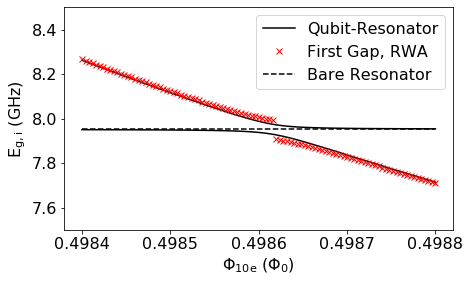

In [39]:
plt.plot(x,Efull[1]-Efull[0],"k-")
plt.plot(x,Efull[2]-Efull[0],"k-",label="Qubit-Resonator")
plt.plot(xl,Edressedl[1],"rx",label="First Gap, RWA")
plt.plot([x[0],x[-1]],[wr,wr],"k--",label="Bare Resonator")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
#plt.xlim(0.4976,0.498)
plt.ylim(7.5,8.5)
plt.legend()

## 3JJ Qubit Resonator Response

For completeness we include the resonator response when a 3JJ qubit is used:

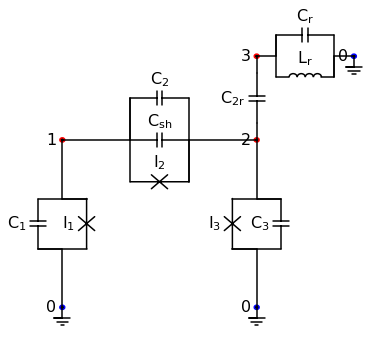

In [40]:
circuit = CircuitSpec("3JJ Circuit")
circuit.addBranch(["C1","I1"],'up',0,False,lead_len=2.0)
circuit.addBranch(["C2","Csh","I2"],'right',1,False,lead_len=2.0)
circuit.addBranch(["C3","I3"],'down',2,True,lead_len=2.0)

rcircuit = circuit.coupleLinearResonator("r",2)
rcircuit.drawCircuit(inline=True)

In [41]:
hamil = HamilSpec(circuit,include_subsystem="r")
hamil.setTruncation(1,10,"charge")
hamil.setTruncation(2,10,"charge")
hamil.prepareOperators()
hamil.getHilbertSpaceSize()

Using existing PyCQED tmp output root directory '/tmp/.pycqed/'.


441

In [42]:
hamil.setDiagConfig(get_vectors=True,eigvalues=20)

In [43]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj=0.3**2
alpha = 0.44
hamil.setParameterValues(
    'C1',Ca*Aj,
    'C2',Ca*Aj*alpha,
    'C3',Ca*Aj,
    'I1',Jc*Aj,
    'I2',Jc*Aj*alpha,
    'I3',Jc*Aj,
    'Csh',45,
    'phi20e',0.5,
    'Cr',400.0,
    'Lr',1000.0,
    'C2r',0.5
)

# Configure the parameter sweep
spec = [
    hamil.sweepSpec('phi20e',0.4,0.6,101)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian',True,None),
    hamil.evalSpec('getResonatorResponse',False,"getHamiltonian",eval_dp=True),
]

In [44]:
sweep = hamil.paramSweep(spec,eval_spec=evals)

In [45]:
x,Erwa,v = hamil.getSweep(sweep,'phi20e',{},evaluable='getResonatorResponse')
Edressed = util.getCircuitLambShift(Erwa)

Text(0, 0.5, '$E_{g,i}$ (GHz)')

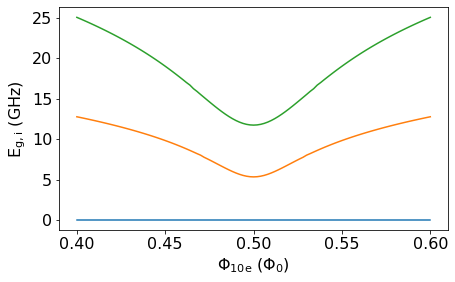

In [46]:
for i in range(3):
    y = Edressed[i]
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

In [47]:
Eres = util.getResonatorShift(Erwa)

Text(0, 0.5, '$\\omega_{r}$ (GHz)')

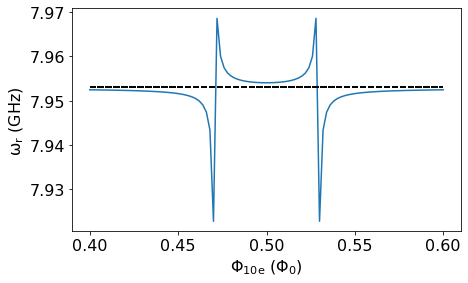

In [48]:
wr = hamil.getSubsystemDerivedParameter('w')
plt.plot(x,Eres[0,0])
plt.plot([x[0],x[-1]],[wr,wr],"k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")